# Clustering with UMAP 

This is an initial test notebook to cluster transit candidates using the Uniform Manifold Approximation and Projection ([UMAP](https://arxiv.org/pdf/1802.03426.pdf)) technique. 
- Reading in our output data
- Cross-referencing any 

## Importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

os.chdir("../")
from scripts.post_processing import *
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
SEED = 42

## Importing files

We'll be importing the output data from the search, but also the current catalog of Eclipsing Binaries (EBs). 
- Where EBs will lie on this projection might give as a better picture of other candidates with similar properties, and help in clustering out false-positive transits.

In [3]:
data = get_output("output_log/test_s6.txt")
metadata = get_metadata("lc_metadata/metadata_sector_6.txt")

In [4]:
ebs = pd.read_csv(
    "catalogs/ebs/hlsp_tess-ebs_tess_lcf-ffi_s0001-s0026_tess_v1.0_cat.csv"
)
ebs_30min = pd.read_csv("catalogs/ebs/eb_cat.txt")
toi_list = pd.read_csv("catalogs/toi/csv-file-toi-catalog.csv", skiprows=4)

In [5]:
xrpstats = pd.read_csv("s6stats.csv", names=["ID", "mstat_xrp", "astat"], skiprows=1)
xrpstats.head()

,ID,mstat_xrp,astat
0,251269189,0.487,0.101711
1,11199201,-0.094,0.289609
2,11197342,-0.238,0.395487
3,234271852,0.104,0.229952
4,237736917,-0.166,0.044972


In [6]:
toi_list.head()

,Parameter Source Pipeline,Stellar Catalog,TIC,Full TOI ID,Signal ID,TOI Disposition,EXOFOP Disposition,TIC Right Ascension,TIC Declination,TMag Value,...,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Alerted,Edited
0,qlp-s31-ffi,NaN,49899799,416.01,1,EB,FP,48.854273,-2.175283,8.2590,...,7.011400,0.000010,4.80000,1.184000,8970.000000,12.878600,"[4, 31]",tropical Jupiter,2019-01-16 19:24:28+00,NaN
1,qlp-s08-faintsearch,tic8,270457662,3434.01,1,PC,PC,135.313850,0.841827,12.2610,...,3.151002,0.000008,0.61200,0.126000,4700.000000,107.064000,"[8, 34]",V-shaped; found in faint-star QLP search,2021-06-16 22:56:33+00,NaN
2,qlp-s11-faintsearch,tic8,241752370,3238.01,1,PC,PC,208.889241,-52.524566,13.5340,...,3.224746,0.000687,3.62100,0.264000,11350.000000,8.776380,[11],found in faint-star QLP search,2021-06-04 13:54:29+00,NaN
3,spoc-s01-s36-b02-L1,tic8.1,237332812,4352.01,1,PC,PC,346.832746,-60.084987,9.3391,...,11.891863,0.000153,4.78248,0.605363,362.689945,45.198753,"[1, 28]",low MES; may be variability,2021-07-28 19:58:07+00,NaN
4,qlp-s15-ffi,gaia-dr2,345996087,1329.01,1,PC,FP,327.480091,44.080133,10.2840,...,2.019760,0.001790,3.39400,0.614000,3963.850000,516.298000,[15],NaN,2019-10-17 00:30:12+00,NaN


In [7]:
data.head()

,file,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,transit_prob
0,tesslc_31474984.pkl,-4.775488,-4.258848,1476.847909,0.954294,0.191044,0.054797,0.145831,-0.004988,0.017945,-0.006,maybeTransit
1,tesslc_147310981.pkl,-6.713624,-2.323528,1472.952645,0.998897,0.149222,0.113888,0.875014,-0.001087,0.116040,0.021,maybeTransit
2,tesslc_349375857.pkl,-4.392541,-4.308605,1483.261256,-2.000000,-2.000000,-2.000000,2.437536,-0.010882,0.788714,0.650,end
3,tesslc_156240404.pkl,-3.204012,-2.432586,1479.683162,1.050542,0.120613,0.035155,0.124998,-0.002877,0.019940,-0.224,maybeTransit
4,tesslc_102213859.pkl,-21.602730,-8.164077,1473.328968,1.036076,0.209138,0.115629,0.354162,-0.052598,0.043567,0.440,maybeTransit


In [8]:
metadata.head()

,file,ticid,ra,dec,magnitude,camera,chip,sector
0,tesslc_709917564.pkl,709917564,97.205928,-7.034400,5.3162,2,3,6
1,tesslc_281413400.pkl,281413400,99.386774,0.590487,14.4688,1,2,6
2,tesslc_176615627.pkl,176615627,87.502666,-0.074062,14.0360,1,1,6
3,tesslc_445939140.pkl,445939140,101.986267,15.189692,14.4591,1,3,6
4,tesslc_738331660.pkl,738331660,98.974853,-36.089093,5.8915,3,1,6


In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data

,file,signal,snr,time,asym_score,width1,width2,duration,depth,peak_lspower,mstat,transit_prob
0,tesslc_31474984.pkl,-4.775488,-4.258848,1476.847909,0.954294,0.191044,0.054797,0.145831,-0.004988,0.017945,-0.006,maybeTransit
1,tesslc_147310981.pkl,-6.713624,-2.323528,1472.952645,0.998897,0.149222,0.113888,0.875014,-0.001087,0.116040,0.021,maybeTransit
2,tesslc_349375857.pkl,-4.392541,-4.308605,1483.261256,-2.000000,-2.000000,-2.000000,2.437536,-0.010882,0.788714,0.650,end
3,tesslc_156240404.pkl,-3.204012,-2.432586,1479.683162,1.050542,0.120613,0.035155,0.124998,-0.002877,0.019940,-0.224,maybeTransit
4,tesslc_102213859.pkl,-21.602730,-8.164077,1473.328968,1.036076,0.209138,0.115629,0.354162,-0.052598,0.043567,0.440,maybeTransit
...,...,...,...,...,...,...,...,...,...,...,...,...
2779720,tesslc_251165455.pkl,-20.225805,-16.623983,1489.953573,-2.000000,-2.000000,-2.000000,0.062500,-0.018668,0.014380,0.095,end
2779721,tesslc_14124935.pkl,-3.886887,-3.831125,1482.326104,0.993408,2.189297,0.755519,0.833314,-0.000421,0.015129,-0.027,maybeTransit
2779722,tesslc_143073386.pkl,-8.452483,-5.125527,1469.244843,-2.000000,-2.000000,-2.000000,0.499999,-0.001029,0.040692,0.063,end
2779723,tesslc_301189457.pkl,-4.768688,-3.070126,1489.870578,-2.000000,-2.000000,-2.000000,0.229168,-0.001514,0.046076,-0.098,end


In [11]:
xrpstats.loc[xrpstats.ID == 709917564]

,ID,mstat_xrp,astat
2737154,709917564,0.154,0.314232


In [12]:
merged_df = metadata.merge(data, on=["file"]).merge(
    xrpstats, left_on="ticid", right_on="ID"
)

In [13]:
ebs_in_data = merged_df[
    (merged_df["ticid"].isin(ebs["tess_id"]))
    | (merged_df["ticid"].isin(ebs_30min["ID"]))
]
ebs_in_data

,file,ticid,ra,dec,magnitude,camera,chip,sector,signal,snr,...,width1,width2,duration,depth,peak_lspower,mstat,transit_prob,ID,mstat_xrp,astat
178,tesslc_302873027.pkl,302873027,94.790559,10.012879,14.30240,1,3,6,-26.086834,-12.075420,...,0.077113,0.038200,0.166666,-0.019880,0.025051,0.351,maybeTransit,302873027,0.292,0.128363
526,tesslc_234608561.pkl,234608561,96.414196,2.580406,14.48130,1,2,6,-12.614066,-4.704187,...,0.097828,0.067272,0.229167,-0.126323,0.161721,1.292,maybeTransit,234608561,1.273,0.704964
648,tesslc_235303635.pkl,235303635,103.221984,8.990292,14.14050,1,3,6,-5.755163,-4.291156,...,7.052160,7.052160,2.354195,-0.005671,0.357672,0.995,artefact,235303635,0.996,0.845126
673,tesslc_176722308.pkl,176722308,87.993125,-5.841013,14.86730,1,1,6,-5.882212,-5.021965,...,0.017569,0.002772,0.041666,-0.249272,0.300154,0.246,point,176722308,0.592,0.922166
745,tesslc_202274770.pkl,202274770,101.908860,6.469411,14.59350,1,3,6,-6.367717,-4.079676,...,0.049517,0.026082,0.104168,-0.023203,0.179205,0.415,maybeTransit,202274770,0.587,0.348214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779213,tesslc_51899999.pkl,51899999,98.055402,-33.432456,12.71390,3,1,6,-8.445587,-4.746819,...,0.047242,0.038859,0.083334,-0.022312,0.325215,0.566,maybeTransit,51899999,0.287,0.441901
2779256,tesslc_42819118.pkl,42819118,96.923603,-0.577885,12.13970,1,2,6,-7.283750,-6.697774,...,-2.000000,-2.000000,0.041667,-0.020443,0.039634,-0.017,end,42819118,0.739,0.519383
2779314,tesslc_127303956.pkl,127303956,85.153113,12.736734,12.04930,1,4,6,-5.027947,-3.041340,...,0.044145,0.027478,0.104165,-0.130971,0.113329,0.197,maybeTransit,127303956,0.940,0.885611
2779494,tesslc_287846583.pkl,287846583,97.624108,-14.954364,6.75357,2,3,6,-7.940289,-4.195154,...,0.046813,0.028233,0.104167,-0.116060,0.210237,1.463,maybeTransit,287846583,1.267,0.688484


In [14]:
ebs_in_data.loc[ebs_in_data.asym_score <= 1.05]

,file,ticid,ra,dec,magnitude,camera,chip,sector,signal,snr,...,width1,width2,duration,depth,peak_lspower,mstat,transit_prob,ID,mstat_xrp,astat
178,tesslc_302873027.pkl,302873027,94.790559,10.012879,14.30240,1,3,6,-26.086834,-12.075420,...,0.077113,3.820021e-02,0.166666,-0.019880,0.025051,0.351,maybeTransit,302873027,0.292,0.128363
526,tesslc_234608561.pkl,234608561,96.414196,2.580406,14.48130,1,2,6,-12.614066,-4.704187,...,0.097828,6.727231e-02,0.229167,-0.126323,0.161721,1.292,maybeTransit,234608561,1.273,0.704964
648,tesslc_235303635.pkl,235303635,103.221984,8.990292,14.14050,1,3,6,-5.755163,-4.291156,...,7.052160,7.052160e+00,2.354195,-0.005671,0.357672,0.995,artefact,235303635,0.996,0.845126
745,tesslc_202274770.pkl,202274770,101.908860,6.469411,14.59350,1,3,6,-6.367717,-4.079676,...,0.049517,2.608194e-02,0.104168,-0.023203,0.179205,0.415,maybeTransit,202274770,0.587,0.348214
929,tesslc_424993847.pkl,424993847,81.811273,-20.927664,14.13910,2,1,6,-15.755256,-10.742174,...,0.056989,3.296935e-02,0.124997,-0.012313,0.022178,0.114,maybeTransit,424993847,0.368,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779154,tesslc_358179412.pkl,358179412,107.085973,-74.221633,12.09190,4,4,6,-3.325514,-2.593801,...,0.165723,2.000000e-07,0.062501,-0.060833,0.776378,0.116,maybeTransit,358179412,0.335,0.937405
2779256,tesslc_42819118.pkl,42819118,96.923603,-0.577885,12.13970,1,2,6,-7.283750,-6.697774,...,-2.000000,-2.000000e+00,0.041667,-0.020443,0.039634,-0.017,end,42819118,0.739,0.519383
2779314,tesslc_127303956.pkl,127303956,85.153113,12.736734,12.04930,1,4,6,-5.027947,-3.041340,...,0.044145,2.747752e-02,0.104165,-0.130971,0.113329,0.197,maybeTransit,127303956,0.940,0.885611
2779494,tesslc_287846583.pkl,287846583,97.624108,-14.954364,6.75357,2,3,6,-7.940289,-4.195154,...,0.046813,2.823306e-02,0.104167,-0.116060,0.210237,1.463,maybeTransit,287846583,1.267,0.688484


In [15]:
tois_in_data = merged_df[(merged_df["ticid"].isin(toi_list["TIC"]))]

Add a column that identifies the known EB's in the data:

In [16]:
merged_df.loc[ebs_in_data.index, "known_class"] = "eb"
merged_df.loc[tois_in_data.index, "known_class"] = "toi"
merged_df["known_class"].fillna(value=False, inplace=True)

In [17]:
# sns.pairplot(data.sample(frac=0.01))

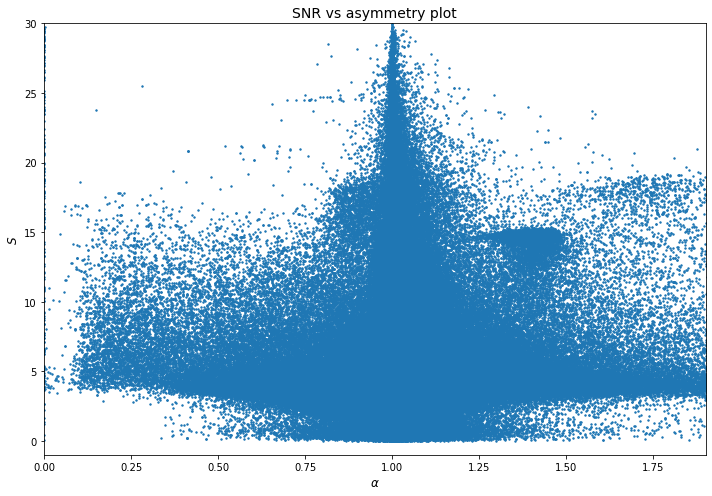

In [18]:
distribution(data.asym_score, abs(data.snr))

In [19]:
interested_region = merged_df[
    (merged_df.transit_prob == "maybeTransit")
    & (merged_df.snr <= -5)
    & (merged_df.asym_score >= 1.0)
]

In [20]:
reducer = umap.UMAP(random_state=SEED)

In [127]:
features = ["snr", "asym_score", "time", "depth", "duration"]
# "peak_lspower", "time", "mstat"

In [128]:
new_data = interested_region[features].sample(frac=0.1)
scaled_data = StandardScaler().fit_transform(new_data)

Explore Lomb-Scargle features which might be a good feature for the clusters:
- Peak power 
- Peak frequency...

embedding: transform first, reduce after

- eg: reducer = fit(data)
- embedding = reducer.transform(data)

In [129]:
embedding = reducer.fit_transform(scaled_data)
embedding.shape

(14178, 2)

Text(0, 0.5, 'latent space y')

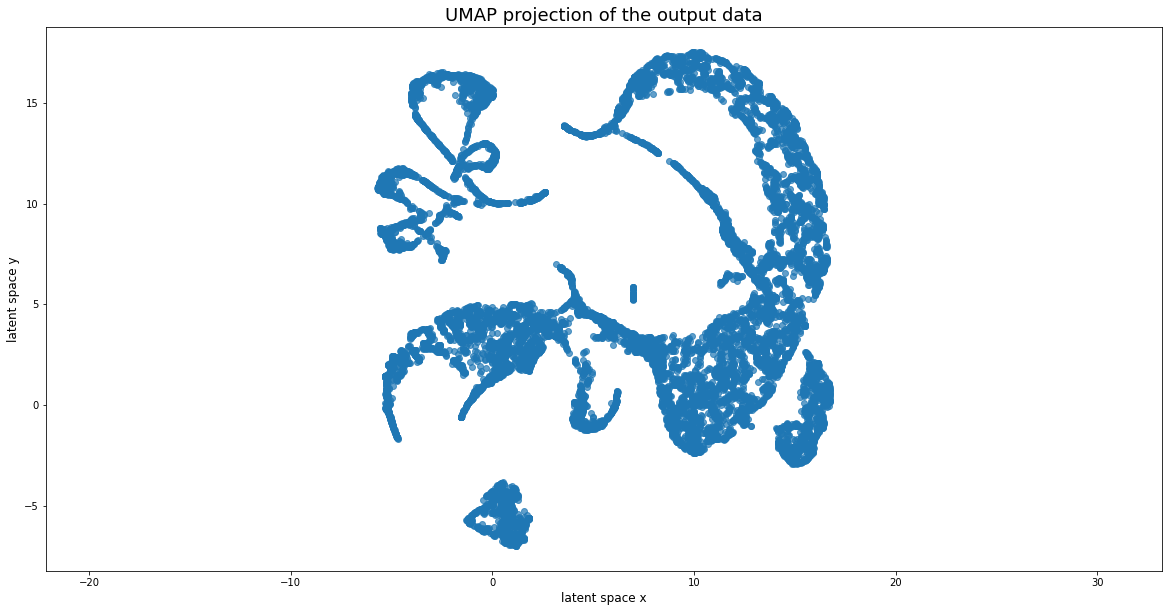

In [130]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7)
# c=[sns.color_palette()[x] for x in merged_df.known_class.map({"toi":0, "eb":1})])
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the output data", fontsize=18)
plt.xlabel("latent space x", fontsize=12)
plt.ylabel("latent space y", fontsize=12)

distances on this latent space don't matter...
- don't map directly back to the high-dimensional space.
- find out what these spaces are!

In [131]:
new_data.shape

(14178, 5)

In [132]:
embedding.shape

(14178, 2)

In [133]:
new_data["embedding_x"] = embedding[:, 0]
new_data["embedding_y"] = embedding[:, 1]

In [134]:
new_data

,snr,asym_score,time,depth,duration,embedding_x,embedding_y
1574220,-13.612186,1.067959,1473.433251,-0.034506,0.124998,11.122420,-1.641834
2581584,-8.130999,1.060736,1473.329004,-0.020315,0.354163,-5.510042,11.198369
855383,-13.712615,1.076313,1473.433178,-0.286107,0.124999,6.035603,13.938174
1156428,-8.757395,1.050331,1473.349975,-0.032018,0.312494,-1.589065,16.102343
2286125,-8.954909,1.073836,1473.349838,-0.023590,0.312492,-1.024116,16.322834
...,...,...,...,...,...,...,...
595266,-5.144198,1.042608,1475.385001,-0.007563,0.458326,-5.078117,2.049961
2181425,-7.205334,1.065098,1476.724423,-0.004247,0.125001,1.447634,3.265530
1047242,-13.804272,1.073030,1473.433320,-0.118812,0.124998,15.970978,11.602483
1789738,-8.377447,1.036338,1473.329131,-0.025421,0.354162,-5.232200,11.487506


### Example: Recovering the false-positives
Let's take 80 of the closest neighbouring points according to `(0,-6)` coordinates on the UMAP projection.

In [201]:
distances = np.linalg.norm(embedding - np.array([0, -6]), axis=1)
new_data["dist"] = distances
closest = new_data.iloc[np.argsort(distances)[:80]]

In [202]:
closest

,snr,asym_score,time,depth,duration,embedding_x,embedding_y,dist
504860,-6.644534,1.214943,1487.015712,-0.140810,0.312493,0.058403,-6.046507,0.074658
431034,-5.165036,1.041736,1485.683274,-0.008890,0.250001,-0.156349,-6.093962,0.182411
2412289,-5.686685,1.092276,1486.182763,-0.005161,0.270837,-0.214809,-6.142048,0.257527
469569,-5.801710,1.017303,1486.141151,-0.004389,0.270836,-0.248656,-6.140213,0.285464
776480,-5.074955,1.032240,1485.677286,-0.004085,0.270830,-0.278805,-6.075608,0.288875
...,...,...,...,...,...,...,...,...
2283363,-7.489444,1.195800,1487.995187,-0.011009,0.187502,0.554937,-6.263181,0.614182
400567,-5.919445,1.146940,1485.366393,-0.010434,0.187498,0.596188,-5.847944,0.615273
2671664,-6.637448,1.072052,1484.224917,-0.004432,0.208336,0.183538,-5.409897,0.617987
463470,-5.144158,1.003515,1487.594438,-0.004708,0.187499,0.437596,-6.436701,0.618221


In [203]:
files = data.loc[data.index & closest.index].file
path = "/storage/astro2/phrdhx/tesslcs/lc_arraydata/sector_6/"
path2 = "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/"

In [204]:
files.head(2)

7223     tesslc_179509057.pkl
18425    tesslc_307583410.pkl
Name: file, dtype: object

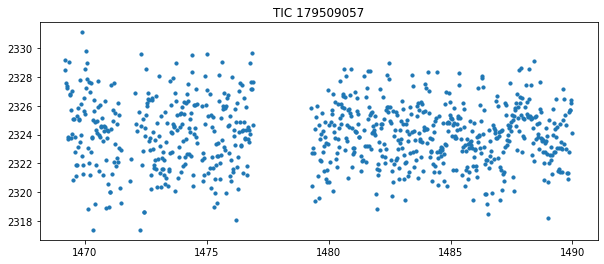

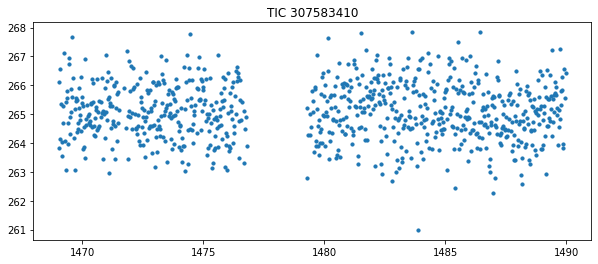

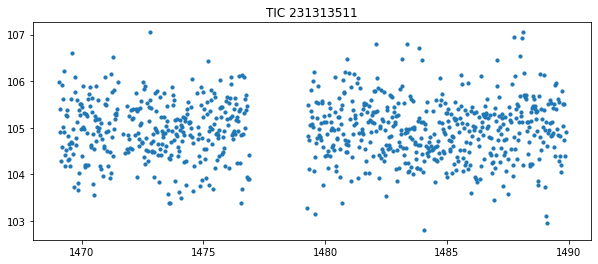

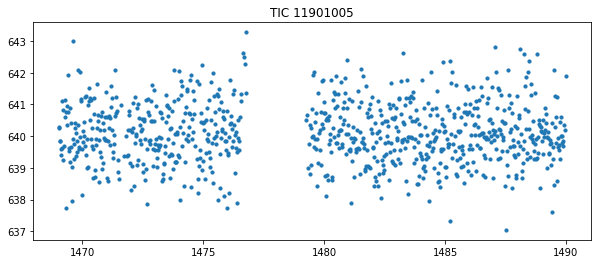

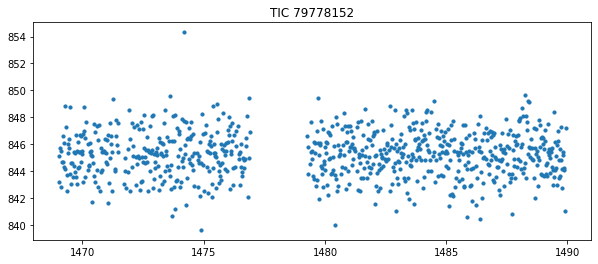

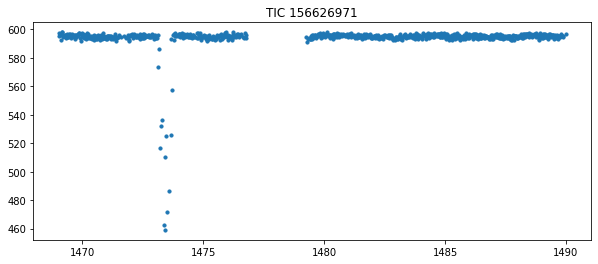

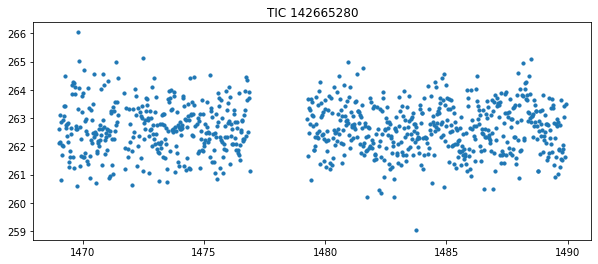

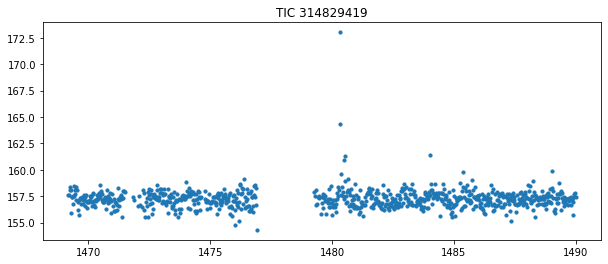

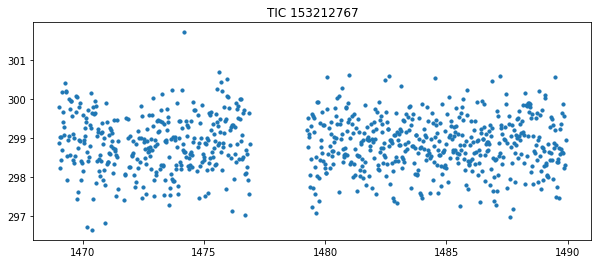

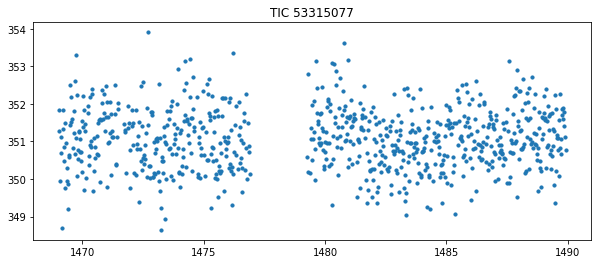

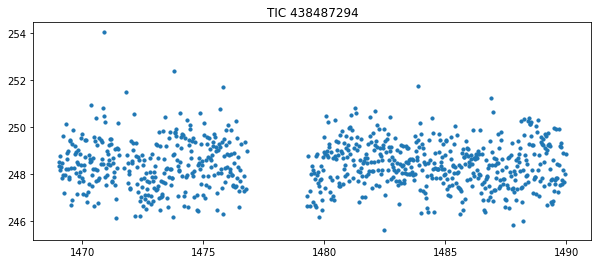

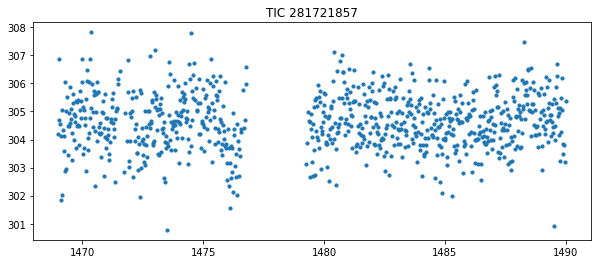

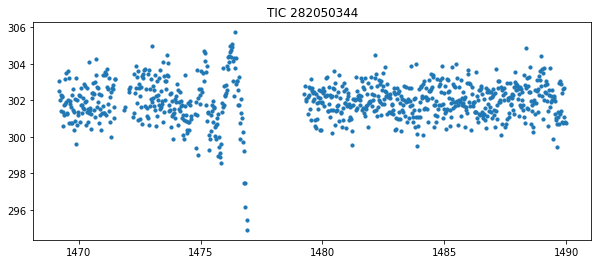

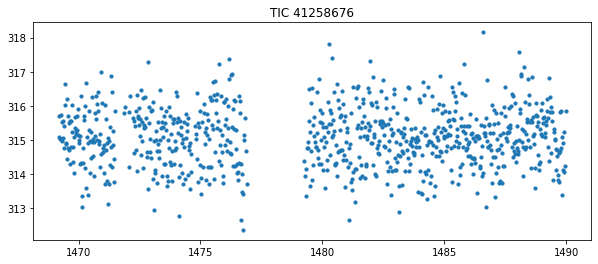

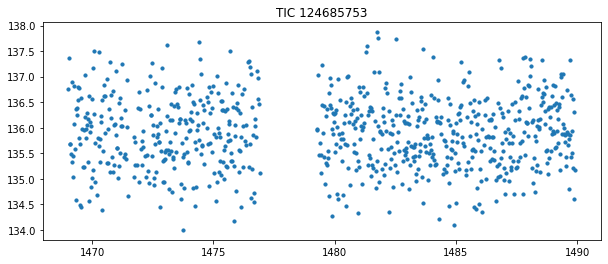

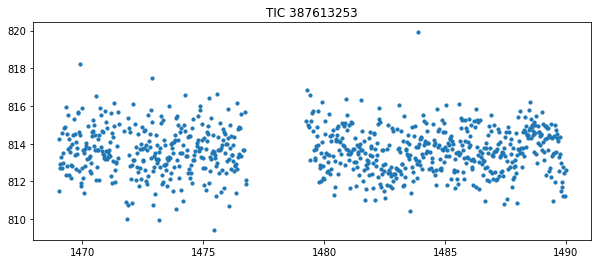

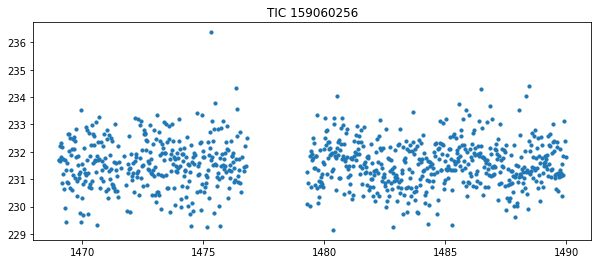

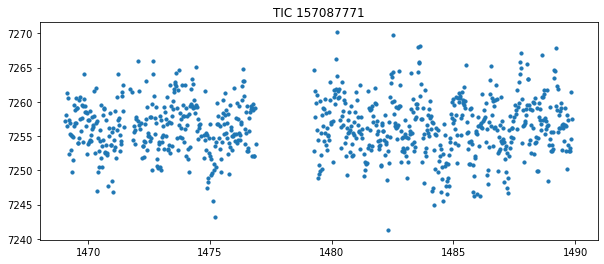

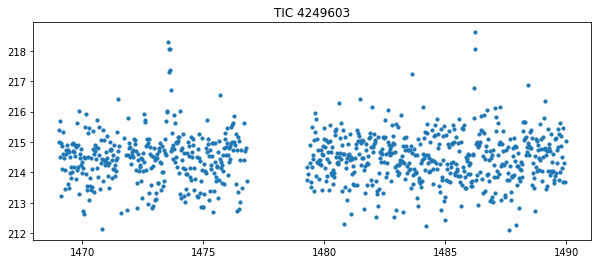

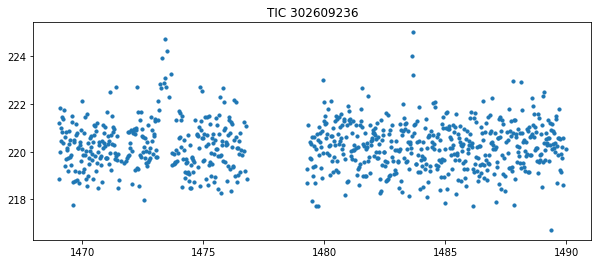

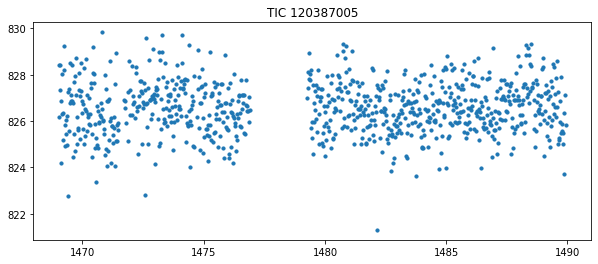

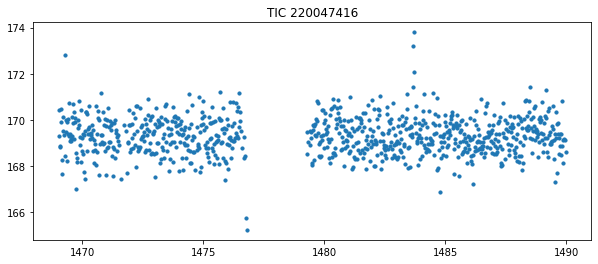

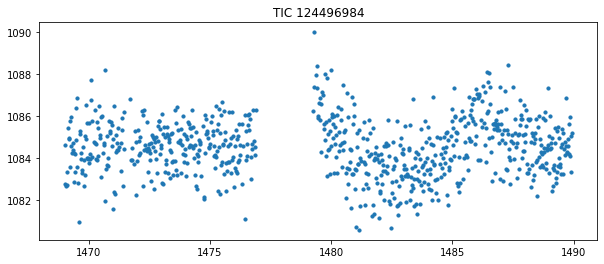

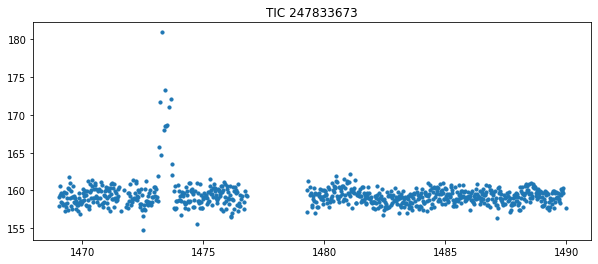

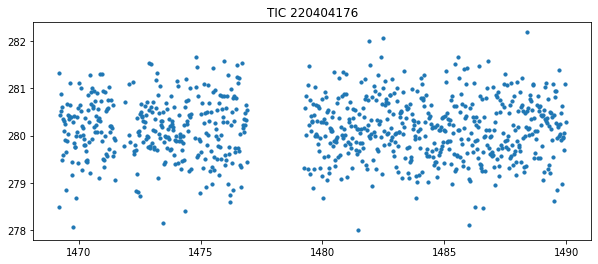

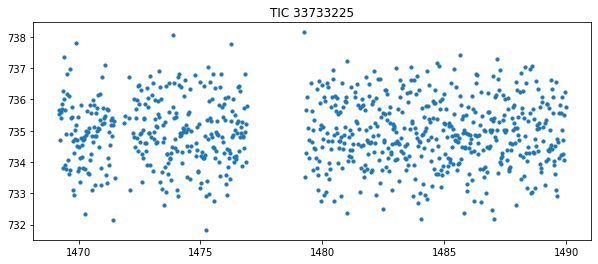

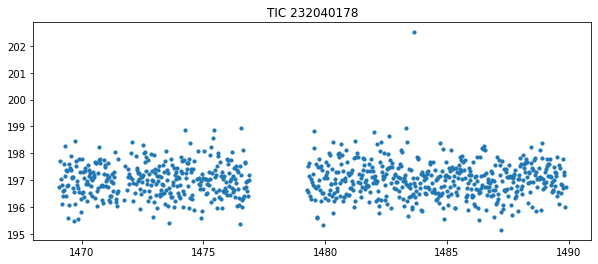

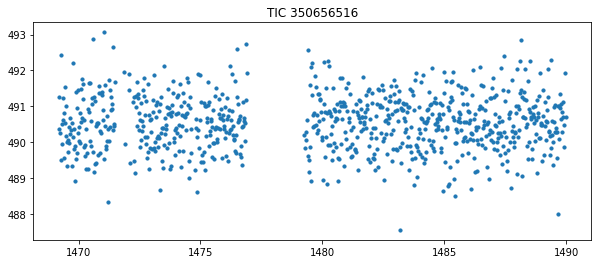

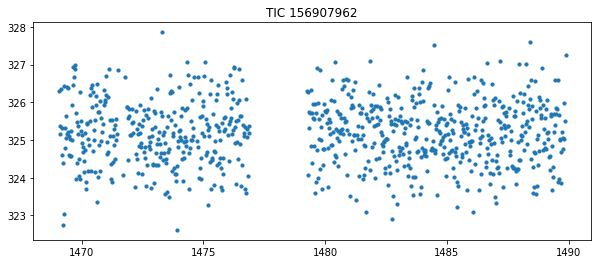

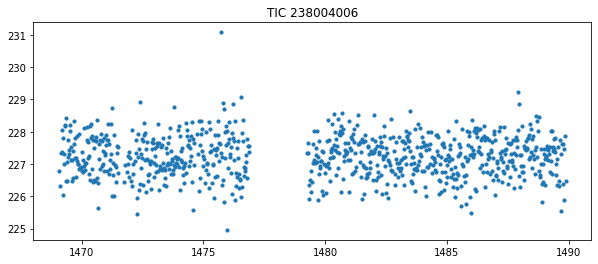

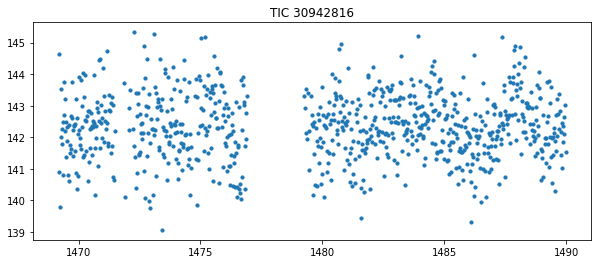

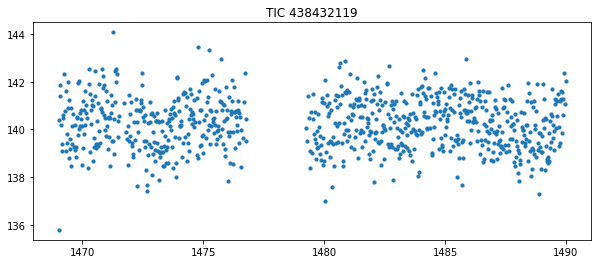

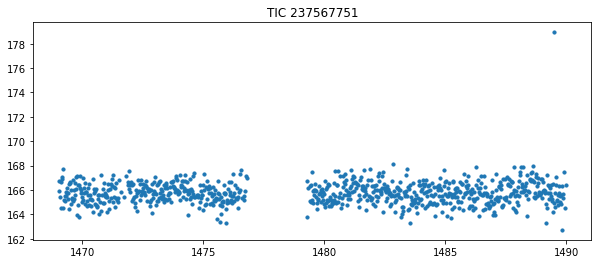

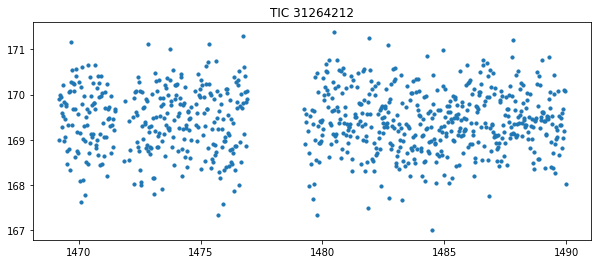

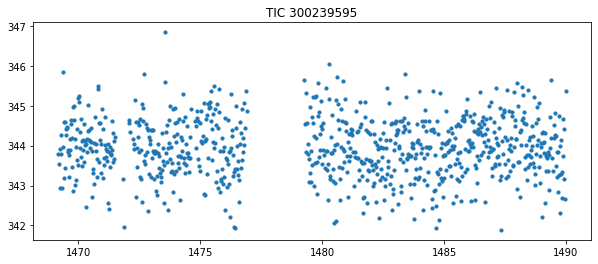

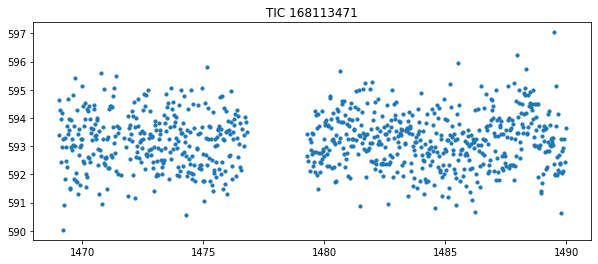

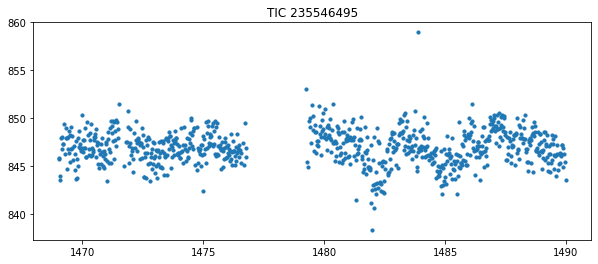

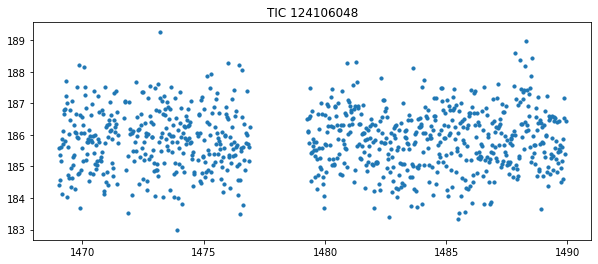

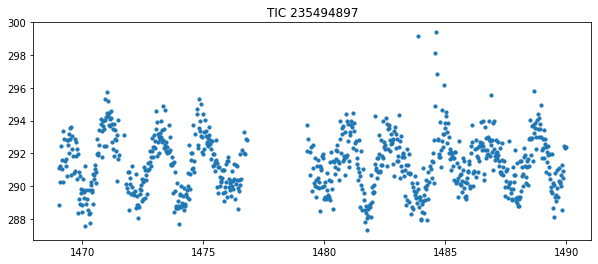

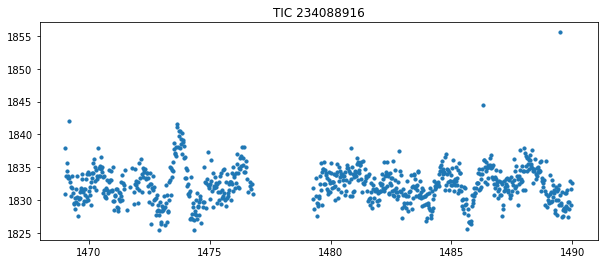

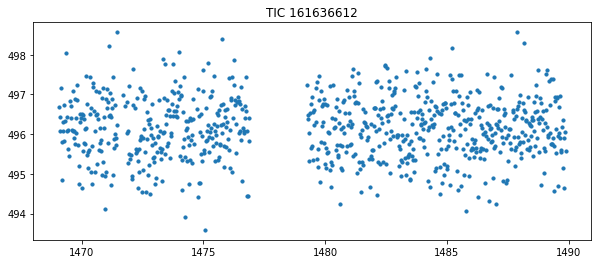

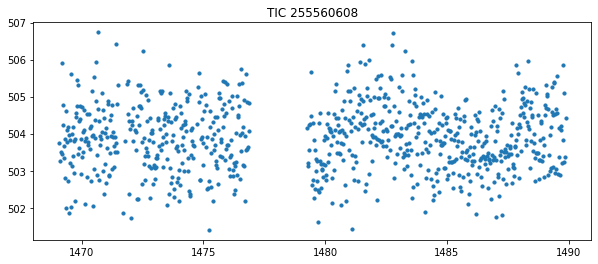

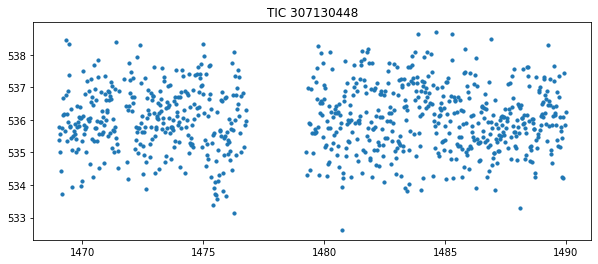

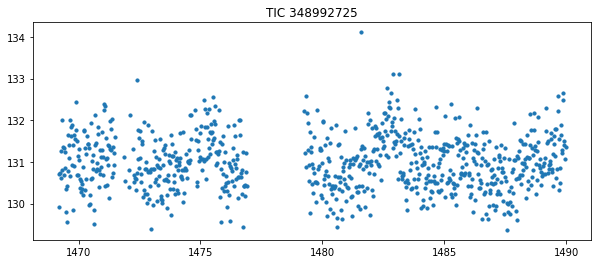

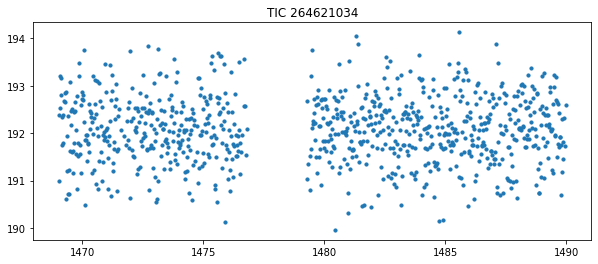

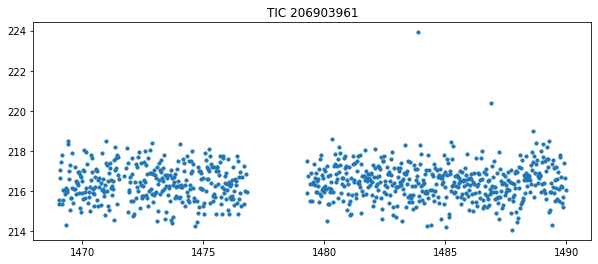

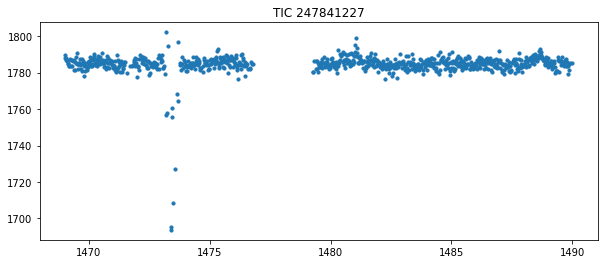

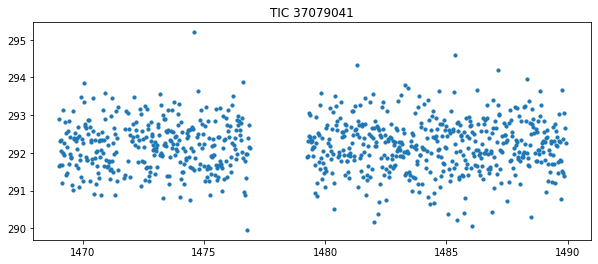

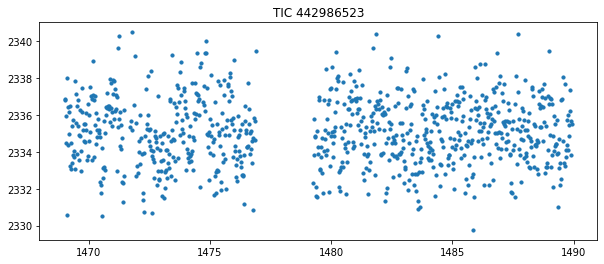

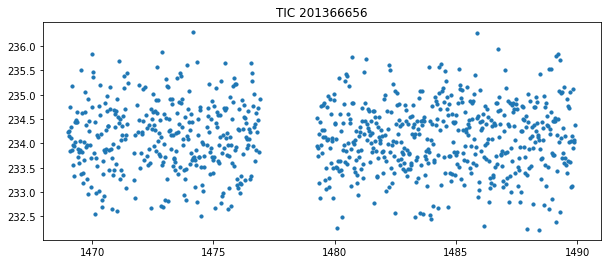

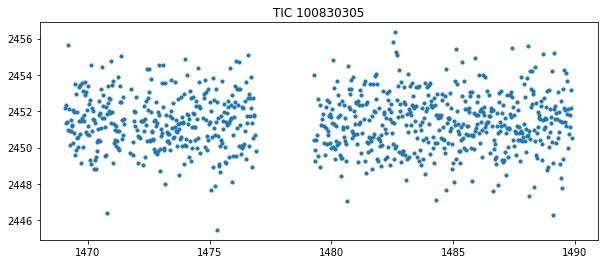

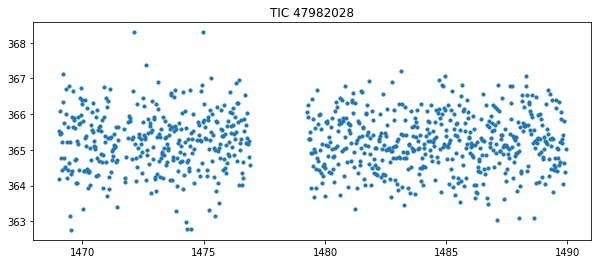

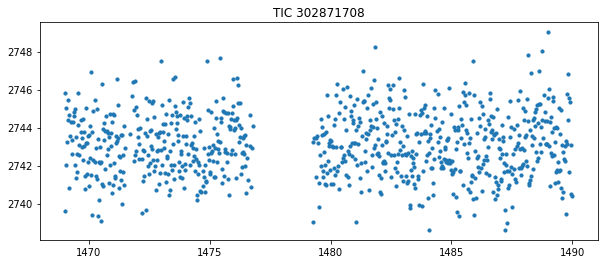

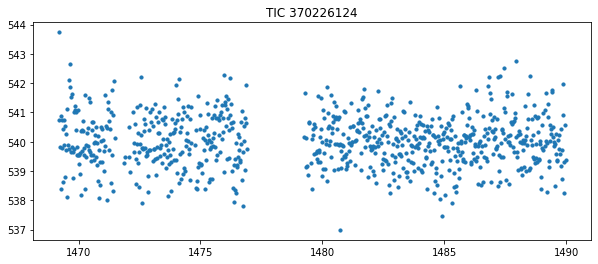

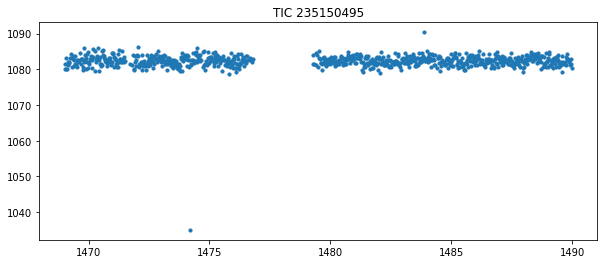

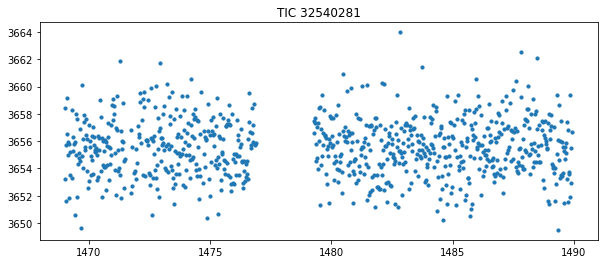

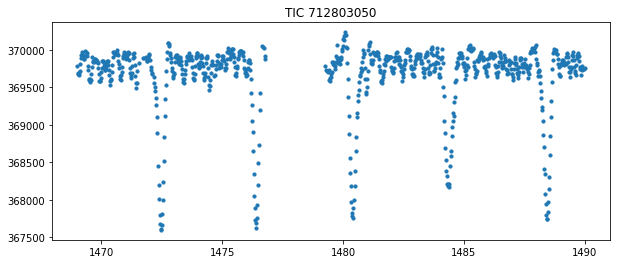

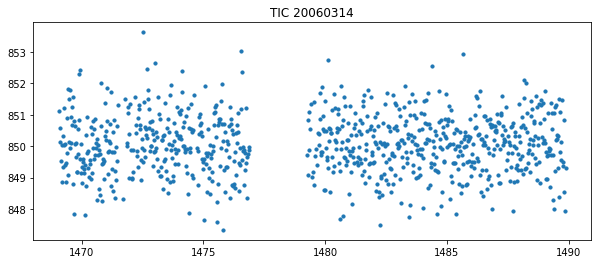

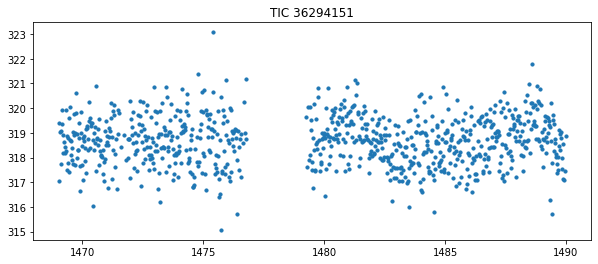

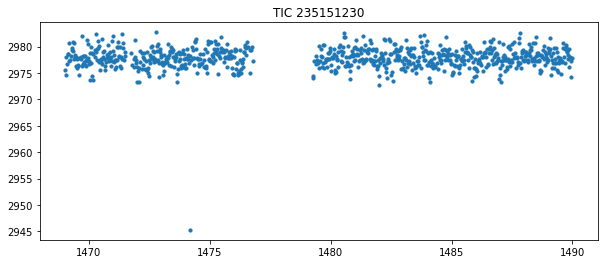

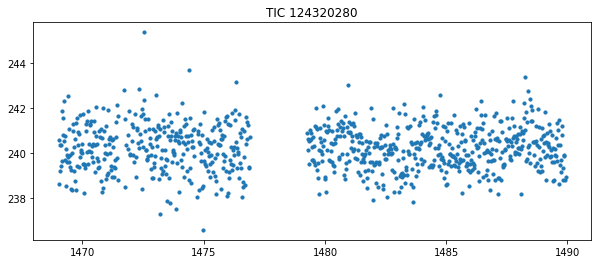

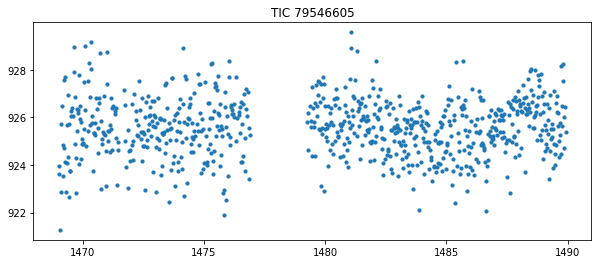

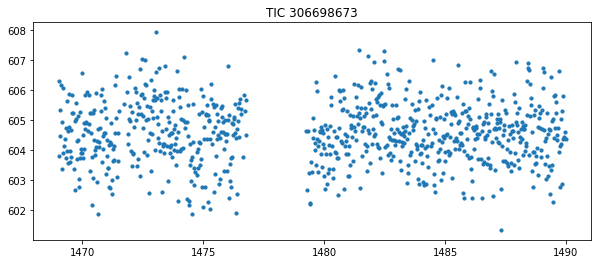

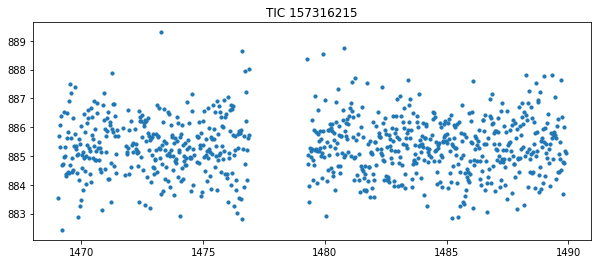

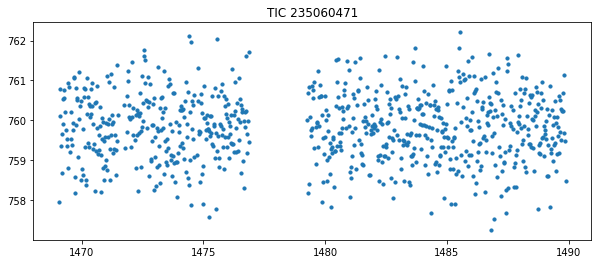

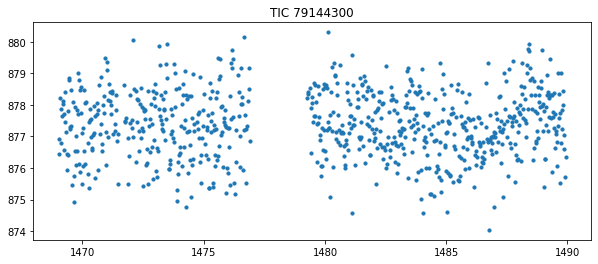

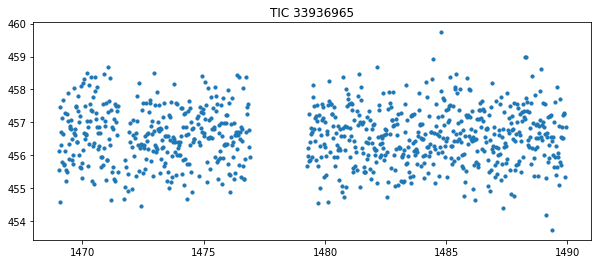

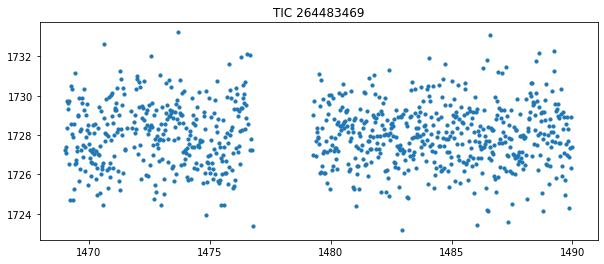

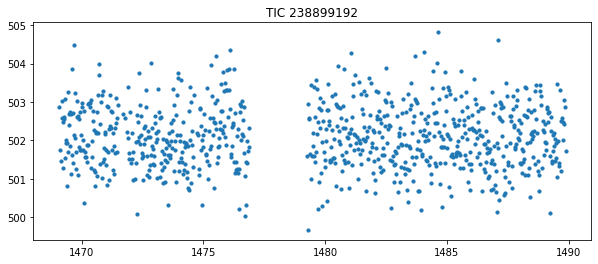

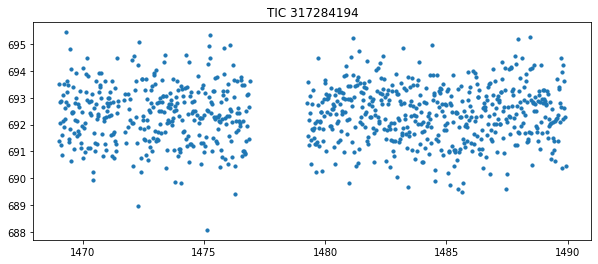

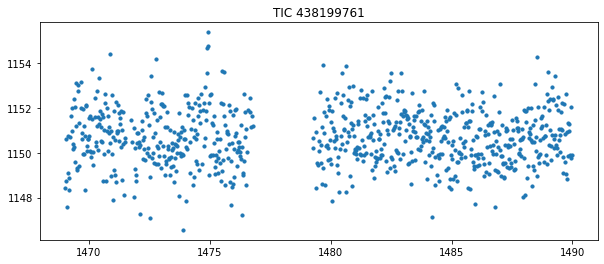

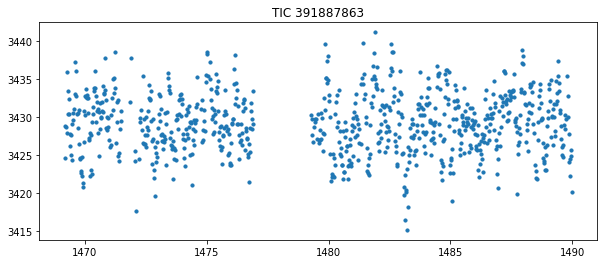

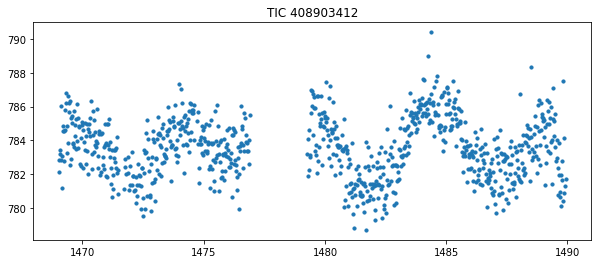

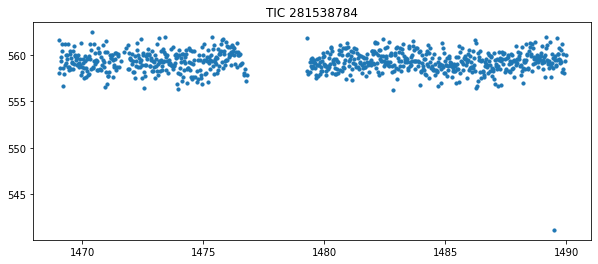

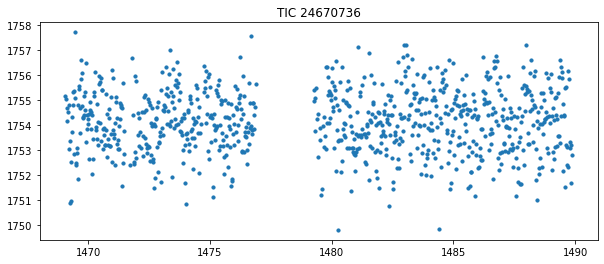

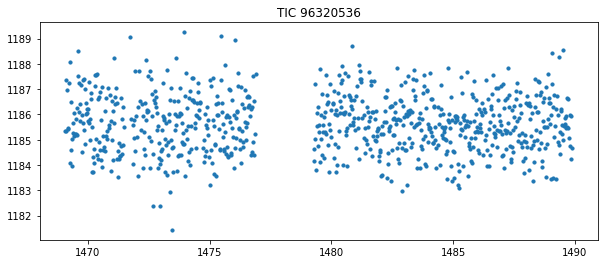

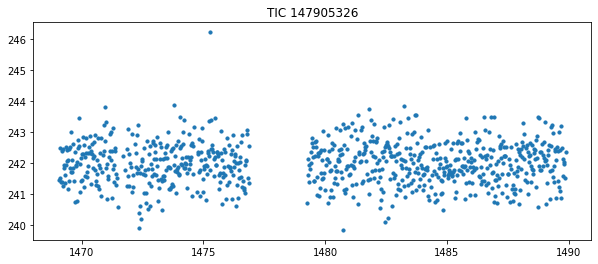

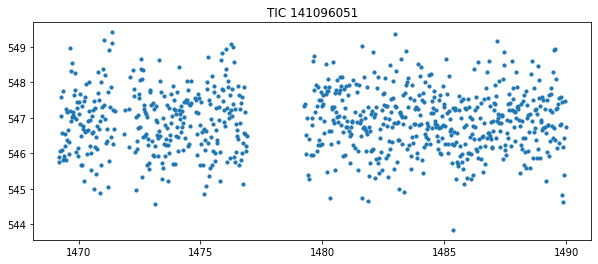

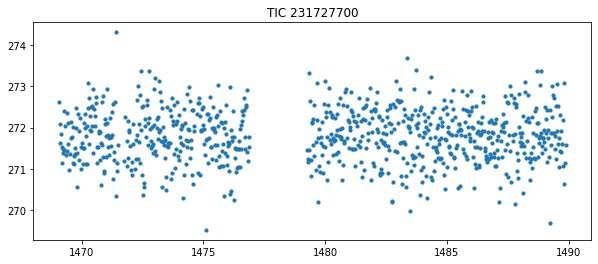

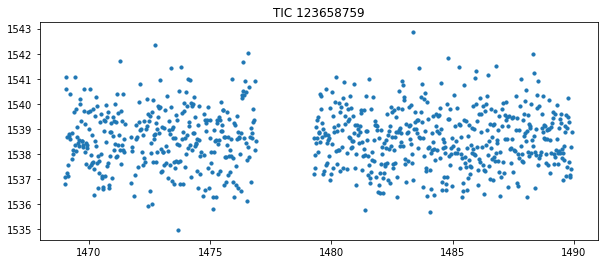

In [205]:
for i in files:
    plt.figure(figsize=(10, 4))
    true_path = glob.glob(os.path.join(path2, f"**/{i}"))[0]
    lc_data, lc_info = import_XRPlightcurve(true_path, sector=6, return_type="pandas")
    plt.scatter(lc_data.time, lc_data["corrected flux"], s=10)
    plt.title(f"TIC {lc_info[0]}")
    plt.show()

In [207]:
a = merged_df.loc[data.index & new_data.index]
a

,file,ticid,ra,dec,magnitude,camera,chip,sector,signal,snr,...,width2,duration,depth,peak_lspower,mstat,transit_prob,ID,mstat_xrp,astat,known_class
154,tesslc_97801854.pkl,97801854,90.359076,16.797994,14.1944,1,4,6,-22.933559,-8.207642,...,0.109361,0.374996,-0.032587,0.036833,0.528,maybeTransit,97801854,-0.039,0.076041,False
208,tesslc_350582006.pkl,350582006,87.055791,-57.391417,14.4372,4,2,6,-5.783428,-5.565657,...,0.000191,0.145833,-0.006334,0.014520,0.061,maybeTransit,350582006,0.251,0.043778,False
900,tesslc_294784620.pkl,294784620,71.354497,-71.092564,14.3273,4,3,6,-7.333348,-5.953144,...,0.005732,0.374996,-0.004865,0.020404,0.038,maybeTransit,294784620,0.278,0.235063,False
950,tesslc_24722209.pkl,24722209,81.484835,-5.991577,5.8311,1,1,6,-7.673912,-5.386740,...,0.070428,0.083331,-0.000922,0.091683,-0.077,maybeTransit,24722209,-0.135,0.350441,False
985,tesslc_156195744.pkl,156195744,86.387879,10.005836,14.2071,1,4,6,-11.120042,-6.210929,...,0.304273,0.583323,-0.010650,0.019098,0.151,maybeTransit,156195744,-0.483,0.043086,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778599,tesslc_264460005.pkl,264460005,81.166478,1.757429,12.9876,1,1,6,-9.506305,-5.663818,...,0.017130,0.145830,-0.005932,0.097537,0.208,maybeTransit,264460005,0.191,0.267623,toi
2778948,tesslc_365779508.pkl,365779508,81.923894,9.822392,12.5437,1,4,6,-20.773472,-8.844357,...,0.048287,0.312492,-0.009722,0.026547,0.410,maybeTransit,365779508,-0.068,0.121081,False
2778950,tesslc_144611697.pkl,144611697,84.547647,6.976661,12.8742,1,4,6,-23.387310,-12.668007,...,0.048334,0.124997,-0.027937,0.032187,0.530,maybeTransit,144611697,0.533,0.000000,False
2779201,tesslc_140604181.pkl,140604181,90.622212,8.237346,12.1715,1,4,6,-14.064232,-6.748508,...,0.142723,0.562494,-0.003855,0.053417,0.196,maybeTransit,140604181,-0.195,-0.017442,False


In [208]:
b = a.loc[a.known_class == "eb"]

**The code below returns the lightcurves of the EB's. Commenting out due to number of outputs**

In [209]:
# for j in b.file:

#     npz = ".npz"
#     npz_file = j.split('.pkl')[0]
#     npz_file += npz
#     #print(os.path.join(arraydata_path,f'{i}'))
#     file_path = os.path.join(path,f'{npz_file}')
#     arraydata = np.load(file_path)

#     file_path2 = glob.glob(os.path.join(path2,f'**/{j}'))[0]
#     lc , _ = import_XRPlightcurve(file_path2, sector=6)

#     fig, ax = plt.subplots(1,2,figsize=(15,3))
#     ax[0].scatter(arraydata['time'],arraydata['flux'],s=8)
#     ax[1].scatter(lc['time'],normalise_flux(lc['corrected flux']),s=8)
#     fig.show()

### Plotting EBs on UMAP projection

In [210]:
ebs = new_data.loc[b.index & new_data.index]

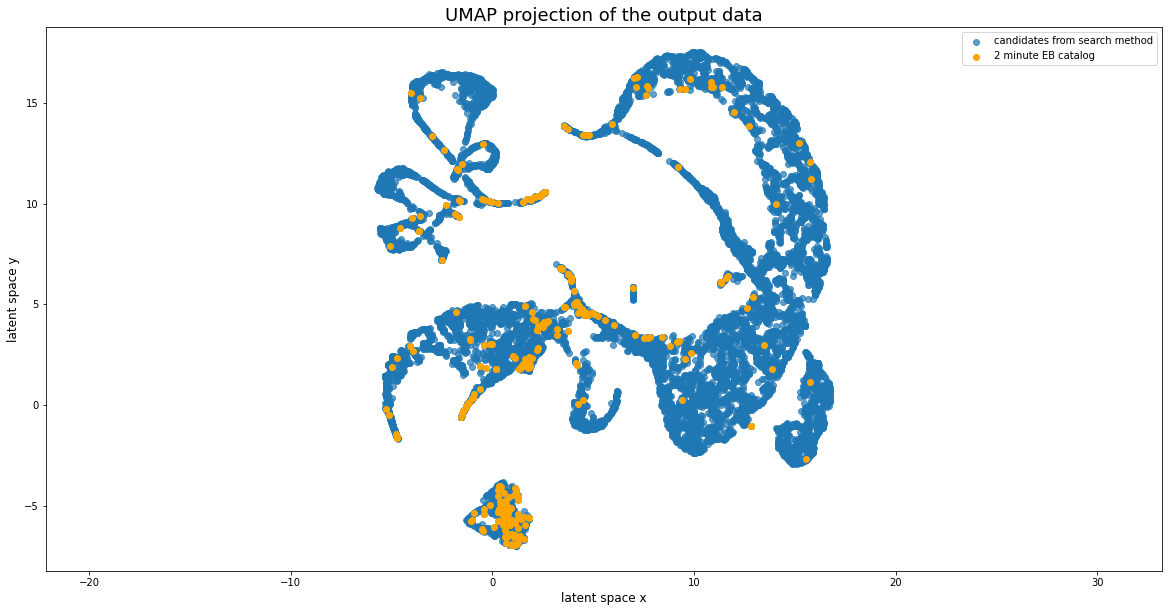

In [211]:
plt.figure(figsize=(20, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], alpha=0.7, label="candidates from search method"
)
# c=[sns.color_palette()[x] for x in data.transit_prob.map({"maybeTransit":0, "artefact":1})])
plt.scatter(ebs.embedding_x, ebs.embedding_y, c="orange", label="2 minute EB catalog")
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the output data", fontsize=18)
plt.xlabel("latent space x", fontsize=12)
plt.ylabel("latent space y", fontsize=12)
plt.legend()
plt.savefig(f"umap_projections/{'_'.join(features)}", dpi=500)

- The cluster at ~ `(0,-5)` is likely EBs, as a fair amount of known EBs fall in this category. 
- However, EBs also fall around other areas on this UMAP, which is an interesting result.
    - We could conclude that this is due to understating/overstating the features with our data, and that maybe a different combination of features might supply improved results.